In [16]:
import re
import random
import pandas as pd
import hashlib

In [17]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2.0e4: age_factor = 1
else: age_factor = 1.05

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.random() for _ in cards_to_age.index]

cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [18]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
"CDK Global Ransomeware, June 2024",37.276941,4.659618,8
Finance Junk,41.693405,5.211676,8
Azure AI Foundry,124.330175,8.288678,15
Workera.ai,316.602181,79.150545,4
IW Migration,365.226226,14.047163,26
Email Auth and Security,366.412991,16.655136,22
Jane Eyre,457.900258,45.790026,10
Azure OpenAI,482.528160,80.421360,6
Dataverse Plugins,487.027287,69.575327,7
AKS,512.051766,64.006471,8


20894.11


<Axes: >

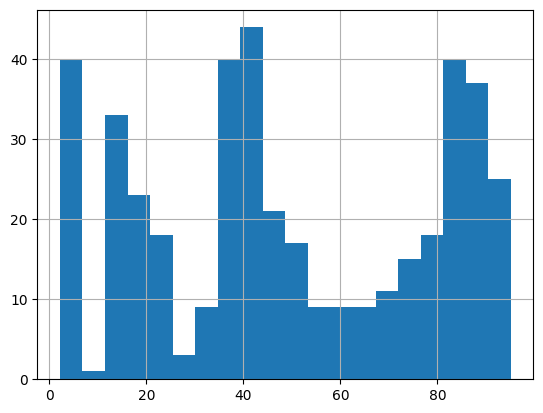

In [19]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [20]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [21]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Headers with fewest notes first

In [22]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Focus on one header

In [23]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [24]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [25]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Headers with greatest age sum first

In [26]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [27]:
# n = 2
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [28]:
n=5
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
existing_cards.head(10)

remake_card_document(existing_cards=existing_cards)

Cards found: 422


## Age max

In [29]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

In [30]:
existing_cards.head(8)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
315,DNS,• DNS Interception:\nThe DNS Interception feat...,40362ab211bda7b7a97e62ae6eed4f99,-89.322124,49.900667,89.322124,-1546.920664,0.670858,0,0
316,DNS,• Security Appliance:\nA dedicated hardware de...,fded51868af75a71b120957cd185e714,-86.942086,49.900667,89.322124,-1546.920664,0.670858,1,0
317,DNS,• DNS Server:\nA server that resolves domain n...,e59954d311450407b6465af67d023e14,-85.354167,49.900667,89.322124,-1546.920664,0.670858,2,0
318,DNS,• Split-Horizon DNS:\nA DNS configuration wher...,7fc86f4ebe74f0dc8f113144d1f785d1,-84.356680,49.900667,89.322124,-1546.920664,0.670858,3,0
319,DNS,• DNS Filtering and Security Policies:\nAdvanc...,3e3700b1f45b28937ccffd496ee03f13,-82.213419,49.900667,89.322124,-1546.920664,0.670858,4,0
382,Home Network Project,Front: What are the key components required to...,4712d6a39d8fdc03df5c3088df006d14,-43.998306,37.123109,43.998306,-1484.924355,0.492951,0,0
383,Home Network Project,Front: What is Docker Compose used for in mana...,37a00a1c9b0695162ff4e06b109dde97,-40.585764,37.123109,43.998306,-1484.924355,0.492951,1,0
385,Home Network Project,Front: Define SSL/TLS Handshake.\n\nBack: The ...,fca0eb85082a856df62a05474dba2617,-40.419838,37.123109,43.998306,-1484.924355,0.492951,2,0
